In [46]:
import torch
from torch import nn
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
from io import StringIO
import seaborn as sns


In [47]:

# 配置参数
SEED = 42
LOOKBACK = 365  # 使用一整年的数据作为历史
FORECAST = 30   # 预测未来30天
BATCH_SIZE = 32

NUM_LAYERS = 4
NUM_HEADS = 8
D_MODEL = 512
D_FF = 2048
DROPOUT = 0.3
LR = 0.0001
EPOCHS = 2000
PATIENCE = 100

# 损失函数权重
val_coef = 1.0    # 预测准确性
season_coef = 0.5 # 季节性一致性

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置随机种子
torch.random.manual_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Using device: cuda
PyTorch version: 2.8.0+cu126
CUDA available: True


In [48]:

# Transformer组件
class Embedding(nn.Module):
    def __init__(self, num_features, d_model):
        super(Embedding, self).__init__()
        self.linear = nn.Linear(num_features, d_model)

    def forward(self, x):
        x = self.linear(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        encoding = encoding.unsqueeze(0)
        self.register_buffer('encoding', encoding)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.drop(attn_weights)
        output = torch.matmul(attn_weights, V)
        return output

    def split_heads(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size, seq_len, self.num_heads, self.d_k)
        return x.transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_len = x.size(0), x.size(1), x.size(2)
        x = x.transpose(1, 2)
        return x.contiguous().view(batch_size, seq_len, self.d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.combine_heads(attn_output)
        output = self.W_o(output)
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.self_attn(x, x, x)
        x = self.drop(x)
        x = self.norm1(x + residual)
        residual = x
        x = self.feed_forward(x)
        x = self.drop(x)
        x = self.norm2(x + residual)
        return x

class Encoder(nn.Module):
    def __init__(self, num_feature, num_layers, d_model, num_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.embedding = Embedding(num_feature, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.drop(x)
        for layer in self.layers:
            x = layer(x)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, encode_ouput, mask):
        residual = x
        x = self.self_attn(x, x, x, mask)
        x = self.drop(x)
        x = self.norm1(x + residual)
        residual = x
        x = self.enc_dec_attn(x, encode_ouput, encode_ouput)
        x = self.drop(x)
        x = self.norm2(x + residual)
        residual = x
        x = self.feed_forward(x)
        x = self.drop(x)
        x = self.norm3(x + residual)
        return x

class Decoder(nn.Module):
    def __init__(self, num_feature, num_layers, d_model, num_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.embedding = Embedding(num_feature, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(d_model, num_feature)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, enc_output, mask):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.drop(x)
        for layer in self.layers:
            x = layer(x, enc_output, mask)
        x = self.fc(x)
        return x

def create_look_ahead_mask(size, device=None):
    mask = torch.triu(torch.ones(size, size), diagonal=1).type(torch.uint8)
    mask = mask == 0
    if device is not None:
        mask = mask.to(device)
    return mask


In [49]:
def fetch_temperature_data():
    """获取气象数据（澳大利亚墨尔本每日最低温度）"""
    import os
    
    # 本地缓存文件路径
    cache_file = "daily_min_temperatures.csv"
    
    # 检查本地缓存是否存在
    if os.path.exists(cache_file):
        print(f"Loading data from local cache: {cache_file}")
        try:
            data = pd.read_csv(cache_file, parse_dates=['Date'])
            print(f"Successfully loaded {len(data)} records from cache")
            return data
        except Exception as e:
            print(f"Error loading from cache: {e}")
            print("Will try to download data instead...")
    
    # 如果缓存不存在或加载失败，从网络获取
    print("Downloading data from UCI repository...")
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
    
    try:
        response = requests.get(url)
        response.raise_for_status()  # 确保请求成功
        data = pd.read_csv(StringIO(response.text), parse_dates=['Date'])
        
        # 保存到本地缓存
        data.to_csv(cache_file, index=False)
        print(f"Downloaded and saved {len(data)} records to local cache")
        
        return data
    except Exception as e:
        print(f"Failed to download data: {e}")
        print("Warning: Using sample data instead.")
        
        # 创建模拟的季节性温度数据作为备份
        dates = pd.date_range(start='1981-01-01', end='1990-12-31', freq='D')
        n = len(dates)
        
        # 创建有季节性的温度数据
        base_temp = 15  # 平均温度
        yearly_cycle = 10 * np.sin(np.linspace(0, 20 * np.pi, n))  # 10年周期
        daily_temp = base_temp + yearly_cycle + np.random.normal(0, 2, n)
        
        data = pd.DataFrame({
            'Date': dates,
            'Temp': daily_temp
        })
        
        # 也保存模拟数据到缓存（可选）
        try:
            data.to_csv(cache_file, index=False)
            print(f"Generated and saved {len(data)} simulated records to local cache")
        except:
            pass
            
        return data

In [50]:

def prepare_data(data, lookback, forecast):
    """准备训练数据"""
    X, y = [], []
    
    # 温度数据是单变量，但我们需要将其转换为2D数组
    values = data['Temp'].values.reshape(-1, 1)
    
    for i in range(lookback, len(values) - forecast):
        X.append(values[i-lookback:i])
        y.append(values[i:i+forecast])
    
    return np.array(X), np.array(y)

def get_data_loaders():
    """获取数据加载器"""
    from sklearn.model_selection import train_test_split
    from torch.utils.data import DataLoader, TensorDataset
    from sklearn.preprocessing import StandardScaler
    
    # 获取温度数据
    temp_data = fetch_temperature_data()
    
    # 保存原始数据用于绘图
    original_data = temp_data.copy()
    
    # 关键修复：使用numpy数组而不是DataFrame列进行标准化
    values = temp_data['Temp'].values.reshape(-1, 1)
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(values)
    temp_data['Temp'] = scaled_values.flatten()
    
    # 准备训练数据
    X, y = prepare_data(temp_data, LOOKBACK, FORECAST)
    
    # 划分训练集和验证集
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=False)
    
    # 转换为PyTorch张量
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    
    # 创建数据加载器
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, val_loader, original_data, scaler


In [51]:

def seasonality_loss(predictions):
    """季节性一致性损失 - 确保预测保持季节性模式"""
    # 计算预测序列的周期性
    seq_len = predictions.size(1)
    
    if seq_len < 30:  # 需要足够长的序列来检测季节性
        return torch.tensor(0.0, device=predictions.device)
    
    # 计算预测序列的自相关性（滞后365天）
    lag = 365  # 年周期
    
    if seq_len <= lag:
        return torch.tensor(0.0, device=predictions.device)
    
    # 提取最近365天的温度（作为参考）
    recent_temp = predictions[:, :lag, 0]
    # 提取预测的未来365天
    future_temp = predictions[:, -lag:, 0]
    
    # 计算相关性
    recent_mean = torch.mean(recent_temp, dim=1, keepdim=True)
    future_mean = torch.mean(future_temp, dim=1, keepdim=True)
    
    recent_centered = recent_temp - recent_mean
    future_centered = future_temp - future_mean
    
    covariance = torch.sum(recent_centered * future_centered, dim=1)
    recent_std = torch.sqrt(torch.sum(recent_centered**2, dim=1) + 1e-8)
    future_std = torch.sqrt(torch.sum(future_centered**2, dim=1) + 1e-8)
    
    # 计算相关系数
    correlation = covariance / (recent_std * future_std + 1e-8)
    
    # 惩罚低相关性（希望保持季节性）
    season_loss = torch.mean((0.3 - correlation).clamp(min=0))  # 目标相关性至少为0.3
    
    return season_loss


In [52]:

def get_loss(predicted, target):
    """损失函数"""
    # 基本MSE损失
    mse_loss = nn.functional.mse_loss(predicted, target)
    
    # 季节性一致性损失
    season_loss = seasonality_loss(predicted)
    
    # 组合损失
    total_loss = val_coef * mse_loss + season_coef * season_loss
    
    return total_loss, mse_loss, season_loss


In [53]:

def infer(encoder, decoder, inputs, scaler, infer_steps):
    """
    inputs: [1, seq_len, 1]
    results: [infer_steps, 1]
    """
    encoder.eval()
    decoder.eval()
    
    # 获取模型所在的设备
    device = next(encoder.parameters()).device
    
    # 确保输入数据在正确的设备上
    inputs = inputs.to(device)
    results = []
    
    with torch.no_grad():
        # 取输入序列的最后一天作为起始
        shift_outputs = inputs[:, -1:, :].clone()
        
        # 编码整个输入序列
        encode = encoder(inputs)
        
        for _ in range(infer_steps):
            # 创建掩码
            mask_size = shift_outputs.size(1)
            mask = create_look_ahead_mask(mask_size, device)
            
            # 解码得到预测
            decode = decoder(shift_outputs, encode, mask)
            
            # 获取最新预测值 [batch_size, 1, features]
            pred_value = decode[:, -1:, :]
            
            # 保存用于最终结果
            results.append(pred_value[0, 0, :].cpu().numpy())
            
            # 将预测值添加到shift_outputs中用于下一次预测
            shift_outputs = torch.cat((shift_outputs, pred_value), dim=1)
    
    # 反标准化 - 确保正确处理形状
    predictions = np.array(results)
    # 确保是2D数组 [n_samples, n_features]
    if predictions.ndim == 1:
        predictions = predictions.reshape(-1, 1)
    
    # 使用与fit时相同的数据结构进行反标准化
    predictions = scaler.inverse_transform(predictions)
    
    return torch.tensor(predictions, device=device, dtype=torch.float32)


In [54]:

def train(encoder, decoder, train_loader, val_loader, scaler, lr, epochs, patience):
    """训练函数"""
    encoder.to(DEVICE)
    decoder.to(DEVICE)
    
    params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(params, lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # 早停机制相关变量
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = {
        'encoder': None,
        'decoder': None,
        'epoch': -1,
        'val_loss': float('inf')
    }
    
    # 用于记录训练过程
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        train_loss = 0
        train_mse_loss = 0
        train_season_loss = 0
        
        for train_x, train_y in train_loader:
            train_x, train_y = train_x.to(DEVICE), train_y.to(DEVICE)
            
            optimizer.zero_grad()
            
            enc_output = encoder(train_x)
            
            mask_size = train_y.size(1)
            mask = create_look_ahead_mask(mask_size, DEVICE)
            
            decoder_input = torch.cat([train_x[:, -1:, :], train_y[:, :-1, :]], dim=1)
            
            dec_output = decoder(decoder_input, enc_output, mask)
            
            # 组合损失
            loss, mse_loss, season_loss = get_loss(dec_output, train_y)
            loss.backward()
            
            # 添加梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_mse_loss += mse_loss.item()
            train_season_loss += season_loss.item()
        
        train_avg_loss = train_loss / len(train_loader)
        train_avg_mse_loss = train_mse_loss / len(train_loader)
        train_avg_season_loss = train_season_loss / len(train_loader)
        train_losses.append(train_avg_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}], Total Loss: {train_avg_loss:.6f}, "
              f"MSE Loss: {train_avg_mse_loss:.6f}, Season Loss: {train_avg_season_loss:.6f}")
        
        # Validation
        encoder.eval()
        decoder.eval()
        val_loss = 0
        val_mse_loss = 0
        val_season_loss = 0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x, val_y = val_x.to(DEVICE), val_y.to(DEVICE)
                
                enc_output = encoder(val_x)
                
                mask_size = val_y.size(1)
                mask = create_look_ahead_mask(mask_size, DEVICE)
                
                decoder_input = torch.cat([val_x[:, -1:, :], val_y[:, :-1, :]], dim=1)
                
                dec_output = decoder(decoder_input, enc_output, mask)
                
                # 组合损失
                loss, mse_loss, season_loss = get_loss(dec_output, val_y)
                
                val_loss += loss.item()
                val_mse_loss += mse_loss.item()
                val_season_loss += season_loss.item()
                
        val_avg_loss = val_loss / len(val_loader)
        val_avg_mse_loss = val_mse_loss / len(val_loader)
        val_avg_season_loss = val_season_loss / len(val_loader)
        val_losses.append(val_avg_loss)
        
        print(f"Val - Total Loss: {val_avg_loss:.6f}, MSE Loss: {val_avg_mse_loss:.6f}, "
              f"Season Loss: {val_avg_season_loss:.6f}")
        
        # 更新学习率
        scheduler.step(val_avg_loss)
        
        # 早停机制检查
        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            patience_counter = 0
            # 保存最佳模型状态
            best_model_state = {
                'encoder': encoder.state_dict().copy(),
                'decoder': decoder.state_dict().copy(),
                'epoch': epoch,
                'val_loss': val_avg_loss
            }
            print(f"Validation loss improved to {val_avg_loss:.6f}, saving model...")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
        
        # 检查是否应该早停
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.6f}")
            # 恢复最佳模型
            encoder.load_state_dict(best_model_state['encoder'])
            decoder.load_state_dict(best_model_state['decoder'])
            break
    
    # 绘制训练损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 如果没有早停，确保最后保存的是最佳模型
    if patience_counter < patience:
        encoder.load_state_dict(best_model_state['encoder'])
        decoder.load_state_dict(best_model_state['decoder'])
        print(f"Training completed. Best validation loss: {best_val_loss:.6f} at epoch {best_model_state['epoch']+1}")
    
    return best_model_state['epoch'] + 1


In [55]:

def plot_temperature_forecast(original_data, predictions, start_idx, forecast_days):
    """绘制温度预测结果"""
    # 获取原始数据中的日期和温度
    dates = original_data['Date'].values
    temps = original_data['Temp'].values
    
    # 确定预测开始日期
    forecast_start_date = dates[start_idx + LOOKBACK]
    forecast_end_date = forecast_start_date + np.timedelta64(forecast_days, 'D')
    
    # 创建预测日期序列
    forecast_dates = pd.date_range(start=forecast_start_date, periods=forecast_days)
    
    # 获取用于预测的历史数据
    history_start = max(0, start_idx)
    history_dates = dates[history_start:start_idx + LOOKBACK]
    history_temps = temps[history_start:start_idx + LOOKBACK]
    
    # 绘制结果
    plt.figure(figsize=(14, 7))
    
    # 绘制历史数据
    plt.plot(history_dates, history_temps, 'b-', label='Historical Data', alpha=0.7)
    
    # 绘制实际数据（如果有的话）
    if start_idx + LOOKBACK + forecast_days < len(dates):
        actual_dates = dates[start_idx + LOOKBACK:start_idx + LOOKBACK + forecast_days]
        actual_temps = temps[start_idx + LOOKBACK:start_idx + LOOKBACK + forecast_days]
        plt.plot(actual_dates, actual_temps, 'g-', label='Actual Data', linewidth=2)
    
    # 绘制预测数据
    plt.plot(forecast_dates, predictions, 'r--', label='Forecast', linewidth=2)
    
    plt.title(f'{forecast_days}-Day Temperature Forecast', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 设置日期格式
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()
    
    # 打印预测统计
    print(f"\nForecast Statistics for {forecast_start_date} to {forecast_end_date}:")
    print(f"Min temperature: {np.min(predictions):.2f}°C")
    print(f"Max temperature: {np.max(predictions):.2f}°C")
    print(f"Average temperature: {np.mean(predictions):.2f}°C")
    print(f"Temperature range: {np.max(predictions) - np.min(predictions):.2f}°C")


Loading data from local cache: daily_min_temperatures.csv
Successfully loaded 3650 records from cache

Starting model training...
Epoch [1/2000], Total Loss: 0.777251, MSE Loss: 0.777251, Season Loss: 0.000000
Val - Total Loss: 0.348643, MSE Loss: 0.348643, Season Loss: 0.000000
Validation loss improved to 0.348643, saving model...
Epoch [2/2000], Total Loss: 0.398755, MSE Loss: 0.398755, Season Loss: 0.000000
Val - Total Loss: 0.303795, MSE Loss: 0.303795, Season Loss: 0.000000
Validation loss improved to 0.303795, saving model...
Epoch [3/2000], Total Loss: 0.382023, MSE Loss: 0.382023, Season Loss: 0.000000
Val - Total Loss: 0.412299, MSE Loss: 0.412299, Season Loss: 0.000000
Validation loss did not improve. Patience: 1/100
Epoch [4/2000], Total Loss: 0.372711, MSE Loss: 0.372711, Season Loss: 0.000000
Val - Total Loss: 0.284112, MSE Loss: 0.284112, Season Loss: 0.000000
Validation loss improved to 0.284112, saving model...
Epoch [5/2000], Total Loss: 0.357511, MSE Loss: 0.357511, S

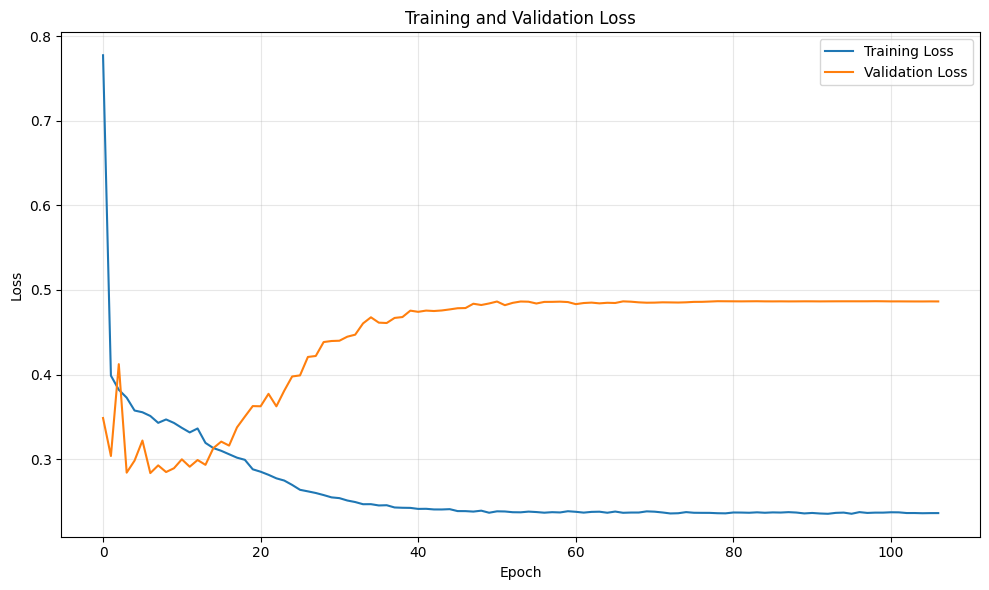


Generating temperature forecast...


In [56]:

# 获取数据
train_loader, val_loader, original_data, scaler = get_data_loaders()

# 获取特征数量（气象数据是单变量）
num_features = 1

# 初始化模型
encoder = Encoder(num_features, NUM_LAYERS, D_MODEL, NUM_HEADS, D_FF, DROPOUT)
decoder = Decoder(num_features, NUM_LAYERS, D_MODEL, NUM_HEADS, D_FF, DROPOUT)

# 训练模型
print("\n" + "="*50)
print("Starting model training...")
print("="*50)
epochs_trained = train(encoder, decoder, train_loader, val_loader, scaler, lr=LR, epochs=EPOCHS, patience=PATIENCE)

# 选择一个样本进行预测
sample_idx = len(val_loader.dataset) // 2
sample_input, sample_output = val_loader.dataset[sample_idx]
sample_input = sample_input.unsqueeze(0)  # 添加批次维度

# 确保模型在正确的设备上
encoder.to(DEVICE)
decoder.to(DEVICE)
sample_input = sample_input.to(DEVICE)

# 进行预测
print("\nGenerating temperature forecast...")
predictions = infer(encoder, decoder, sample_input, scaler, FORECAST)

# 获取实际数据用于比较（如果有的话）
actual_start = sample_idx + len(train_loader.dataset)
if actual_start + LOOKBACK + FORECAST < len(original_data):
    actual_temps = original_data['Temp'].iloc[actual_start + LOOKBACK:actual_start + LOOKBACK + FORECAST].values
else:
    actual_temps = None


In [57]:

# 打印预测结果
print("\nTemperature Forecast (next 30 days):")
forecast_temps = predictions.cpu().numpy().flatten()
for i, temp in enumerate(forecast_temps):
    print(f"Day {i+1}: {temp:.2f}°C")



Temperature Forecast (next 30 days):
Day 1: 14.70°C
Day 2: 12.85°C
Day 3: 12.41°C
Day 4: 12.53°C
Day 5: 12.69°C
Day 6: 12.60°C
Day 7: 12.61°C
Day 8: 12.70°C
Day 9: 12.93°C
Day 10: 13.28°C
Day 11: 13.56°C
Day 12: 13.67°C
Day 13: 13.75°C
Day 14: 13.85°C
Day 15: 13.98°C
Day 16: 14.10°C
Day 17: 14.18°C
Day 18: 14.20°C
Day 19: 14.17°C
Day 20: 14.07°C
Day 21: 13.90°C
Day 22: 13.69°C
Day 23: 13.45°C
Day 24: 13.23°C
Day 25: 13.08°C
Day 26: 12.99°C
Day 27: 12.93°C
Day 28: 12.90°C
Day 29: 12.90°C
Day 30: 12.90°C


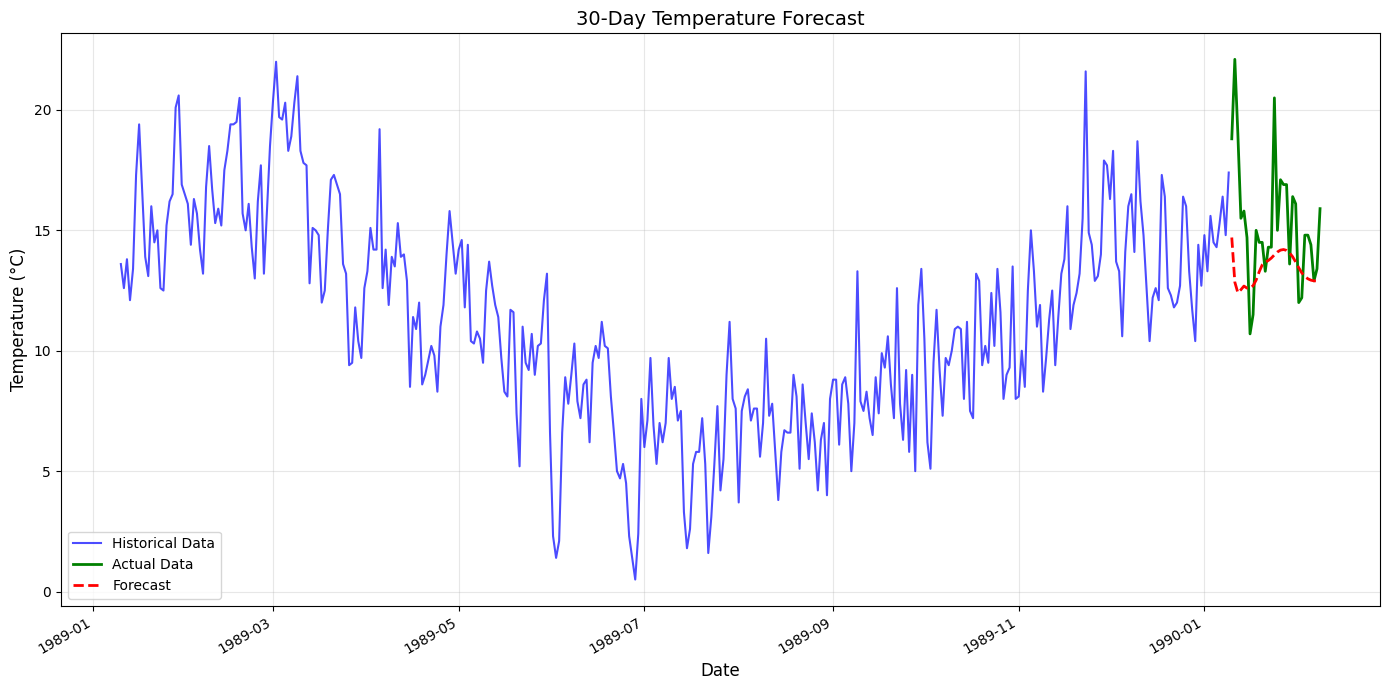


Forecast Statistics for 1990-01-10T00:00:00.000000000 to 1990-02-09T00:00:00.000000000:
Min temperature: 12.41°C
Max temperature: 14.70°C
Average temperature: 13.36°C
Temperature range: 2.29°C


In [58]:

# 绘制预测结果
plot_temperature_forecast(original_data, forecast_temps, actual_start, FORECAST)


In [59]:

# 如果有实际数据，计算并显示误差
if actual_temps is not None and len(actual_temps) == FORECAST:
    mse = np.mean((forecast_temps - actual_temps) ** 2)
    mae = np.mean(np.abs(forecast_temps - actual_temps))
    print(f"\nForecast Error Metrics (compared to actual data):")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.2f}°C")



Forecast Error Metrics (compared to actual data):
MSE: 9.3588
MAE: 2.30°C


In [60]:

# 额外：测试模型对季节性的捕捉能力
print("\n" + "="*50)
print("Testing model's ability to capture seasonality...")
print("="*50)



Testing model's ability to capture seasonality...



Forecast starting from 1982-01-01 00:00:00:


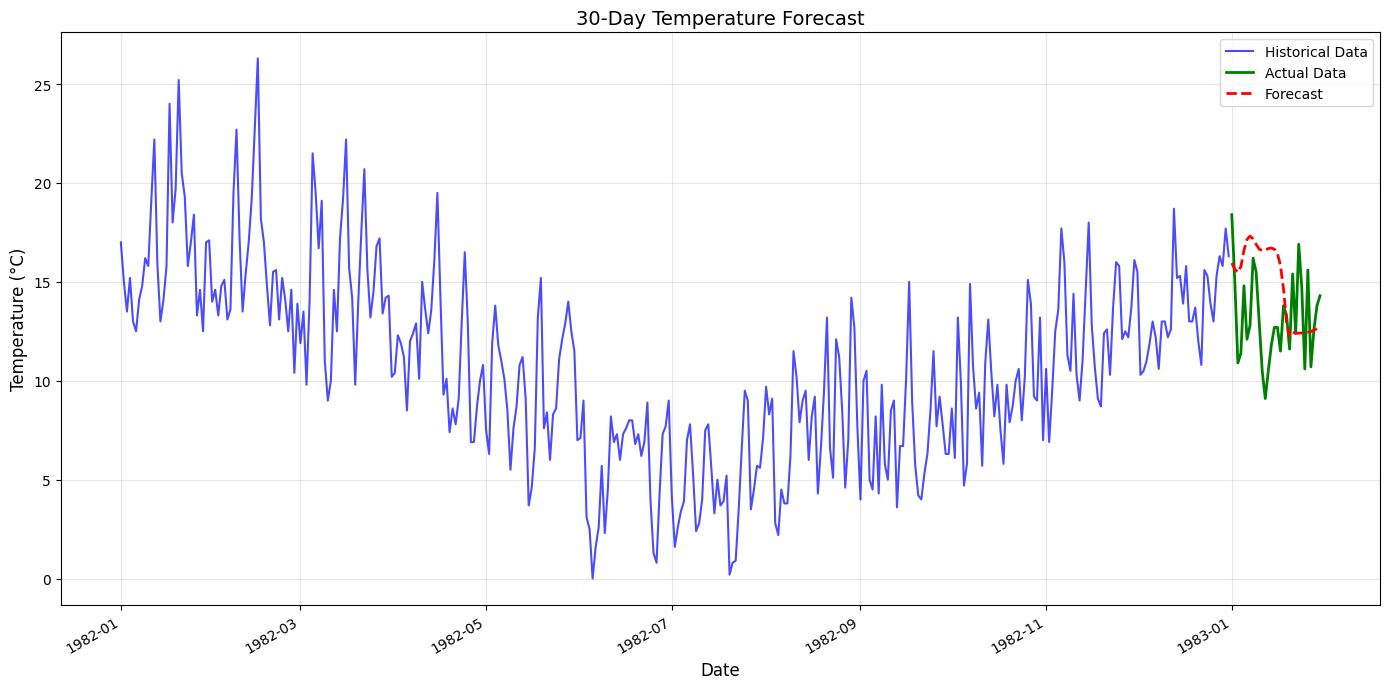


Forecast Statistics for 1983-01-01T00:00:00.000000000 to 1983-01-31T00:00:00.000000000:
Min temperature: 12.26°C
Max temperature: 17.31°C
Average temperature: 14.83°C
Temperature range: 5.05°C

Forecast starting from 1983-01-01 00:00:00:


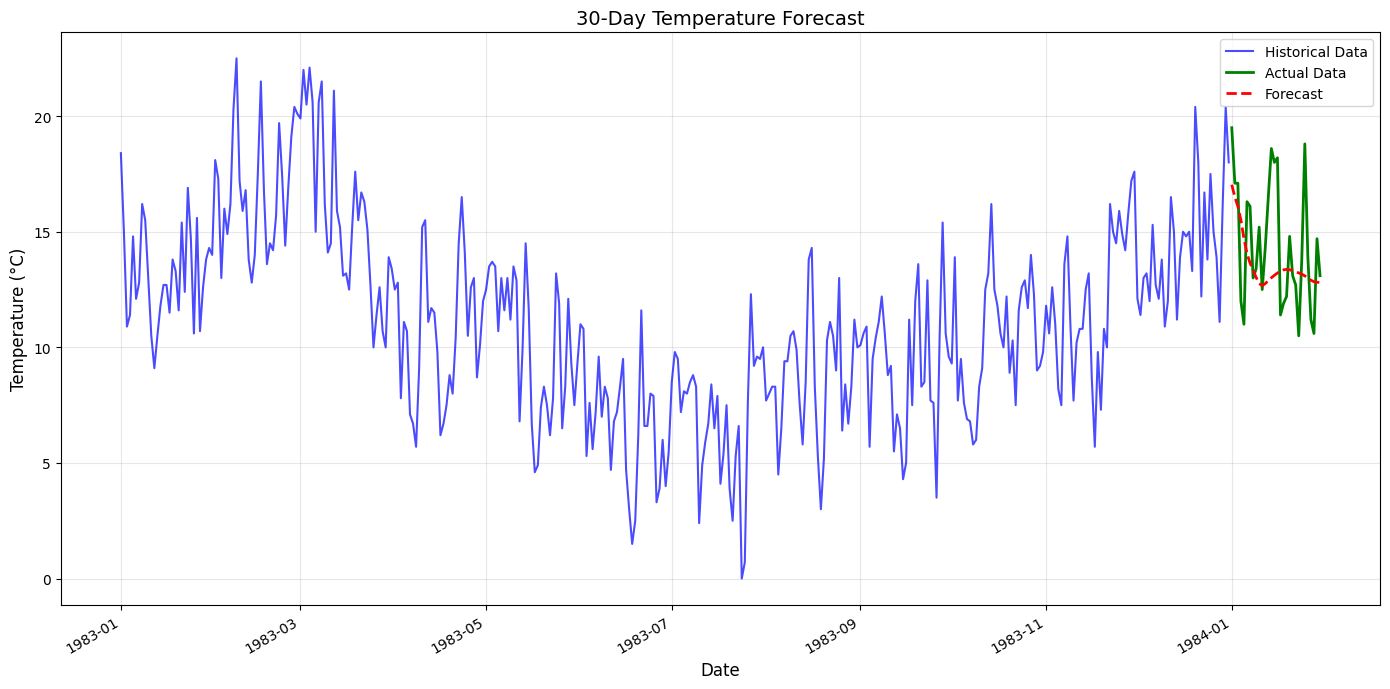


Forecast Statistics for 1984-01-01T00:00:00.000000000 to 1984-01-31T00:00:00.000000000:
Min temperature: 12.67°C
Max temperature: 17.03°C
Average temperature: 13.61°C
Temperature range: 4.36°C

Forecast starting from 1984-01-01 00:00:00:


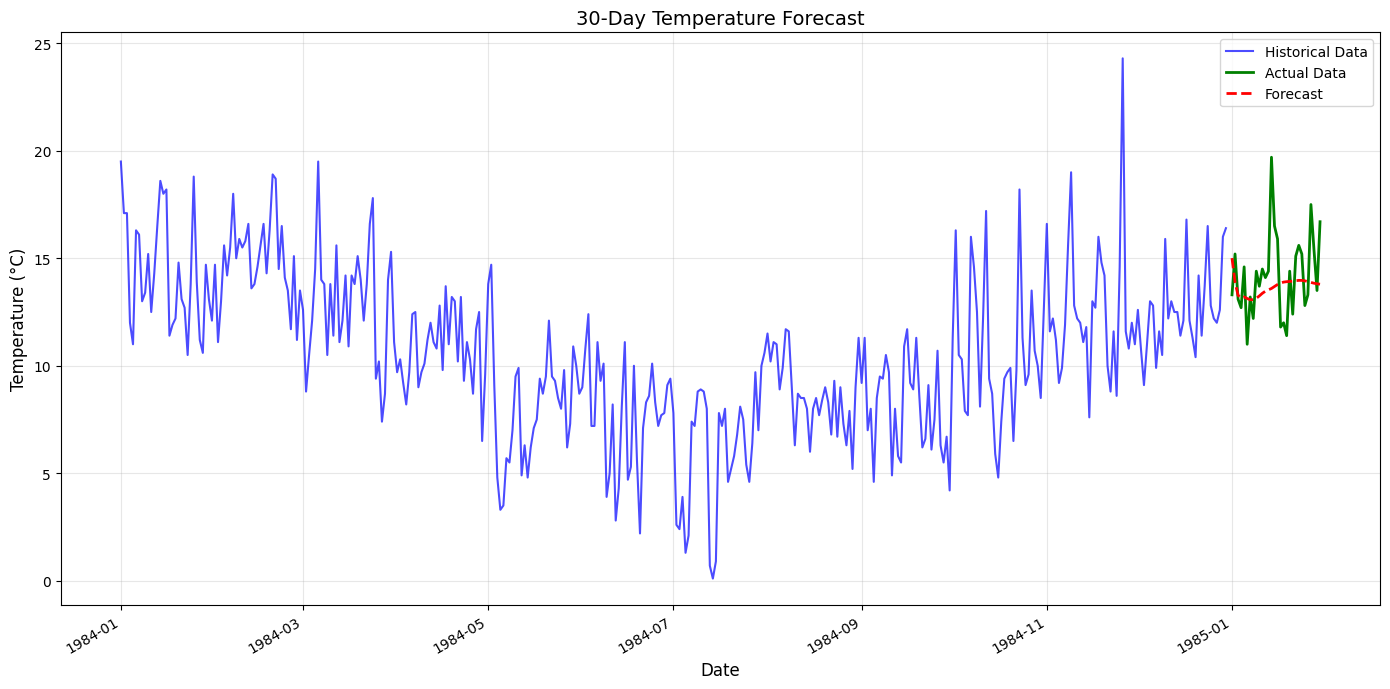


Forecast Statistics for 1985-01-01T00:00:00.000000000 to 1985-01-31T00:00:00.000000000:
Min temperature: 13.07°C
Max temperature: 15.01°C
Average temperature: 13.67°C
Temperature range: 1.94°C

Forecast starting from 1989-12-02 00:00:00:


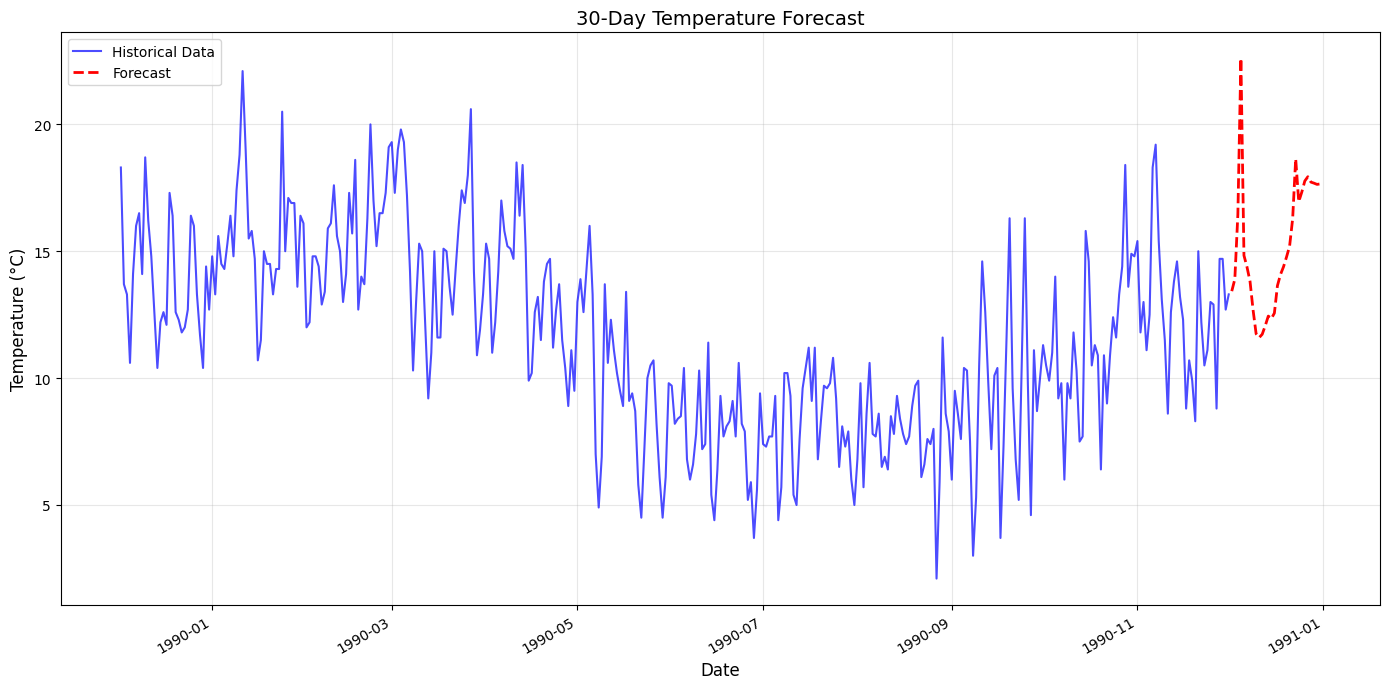


Forecast Statistics for 1990-12-02T00:00:00.000000000 to 1991-01-01T00:00:00.000000000:
Min temperature: 11.60°C
Max temperature: 22.60°C
Average temperature: 15.14°C
Temperature range: 11.01°C


In [61]:

# 选择一年中的不同时间点进行预测
season_test_points = [
    365,      # 1年后
    365*2,    # 2年后
    365*3,    # 3年后
    len(original_data) - LOOKBACK - FORECAST  # 最近的数据
]

for start_idx in season_test_points:
    if start_idx < 0 or start_idx + LOOKBACK + FORECAST > len(original_data):
        continue
    
    # 准备输入数据
    input_data = original_data['Temp'].values[start_idx:start_idx+LOOKBACK].reshape(1, LOOKBACK, 1)
    input_data = scaler.transform(input_data[0]).reshape(1, LOOKBACK, 1)
    input_tensor = torch.tensor(input_data, dtype=torch.float32).to(DEVICE)
    
    # 生成预测
    predictions = infer(encoder, decoder, input_tensor, scaler, FORECAST)
    forecast_temps = predictions.cpu().numpy().flatten()
    
    # 绘制结果
    print(f"\nForecast starting from {original_data['Date'].iloc[start_idx]}:")
    plot_temperature_forecast(original_data, forecast_temps, start_idx, FORECAST)